In [41]:
import tiktoken
tokenpath = "nfs/custom_tokenizer_mental.tokenizer.json"

# tokenizer = tiktoken.get_encoding('gpt2')
# vocab_size = tokenizer.n_vocab

In [42]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

bpetokenizer = Tokenizer(models.BPE())
bpetokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

files = ["nfs/mental_health_data.dev.txt"]  # your 1.5 M-word text file

# 4. Train with a small vocab.
bpetrainer = trainers.BpeTrainer(
    vocab_size=8000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"]
)

bpetokenizer.train(files, bpetrainer)
bpetokenizer.save(tokenpath)




In [41]:
# tokenizer.encode("Love me like you do")
# tokenizer.n_vocab

In [43]:
from transformers import PreTrainedTokenizerFast
tok = PreTrainedTokenizerFast(tokenizer_file=tokenpath)
vocab_size = tok.vocab_size


In [44]:
tok.encode("Love me like you do")

[5084, 114, 179, 106, 262]

In [45]:
import torch

# use cpu or gpu based on your system
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

data_dir = "nfs/mental_health_data.dev.txt"
text = open(data_dir, 'r', encoding='utf-8').read()

data = torch.tensor(tok.encode(text), dtype=torch.long, device=device)

In [46]:
train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 512  # number of tokens processed in a single batch
train_split = 0.7  # percentage of data to use from total data for training

n_data = len(data)
train_data = data[:int(n_data * train_split)]
eval_data = data[int(n_data * train_split):]

In [47]:
num_tokens = data.numel()
print(f"Number of tokens in dataset: {num_tokens}")
print(f"Vocab size: {vocab_size}")

Number of tokens in dataset: 35110819
Vocab size: 8000


In [48]:
class DataLoader:
    def __init__(self, tokens, batch_size, context_length) -> None:
        self.tokens = tokens
        self.batch_size = batch_size
        self.context_length = context_length

        self.current_position = 0

    def get_batch(self) -> torch.tensor:
        b, c = self.batch_size, self.context_length

        start_pos = self.current_position
        end_pos = self.current_position + b * c + 1

        # if the batch exceeds total length, get the data till last token
        # and take remaining from starting token to avoid always excluding some data
        add_data = -1 # n, if length exceeds and we need `n` additional tokens from start
        if end_pos > len(self.tokens):
            add_data = end_pos - len(self.tokens)
            end_pos = len(self.tokens)

        d = self.tokens[start_pos:end_pos]
        if add_data != -1:
            d = torch.cat([d, self.tokens[:add_data]])

        x = (d[:-1]).view(b, c)  # inputs
        y = (d[1:]).view(b, c)  # targets

        self.current_position += b * c # set the next position
        if self.current_position > len(self.tokens) - 1:
            self.current_position = 0
        return x, y

train_loader = DataLoader(train_data, train_batch_size, context_length)
eval_loader = DataLoader(eval_data, eval_batch_size, context_length)

In [49]:
xb, yb = train_loader.get_batch()
print(xb.shape, yb.shape)

torch.Size([16, 512]) torch.Size([16, 512])


In [50]:
d_model = 512 
n_heads = 4
n_layers = 2

In [51]:
from model import GPT

m = GPT(vocab_size=vocab_size, d_model=d_model, n_heads=n_heads, n_layers=n_layers, context_length=context_length).to(device)
# m = torch.compile(m)

In [52]:
print(m)
print(f"Total Parameters: {round(sum(p.numel() for p in m.parameters() if p.requires_grad) / 1_000_000)}M")

GPT(
  (wte): Embedding(8000, 512)
  (wpe): PositionalEncoding()
  (blocks): ModuleList(
    (0-1): 2 x GPTBlock(
      (att): MultiHeadAttention(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (fc_out): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (fcn): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
    )
  )
  (linear1): Linear(in_features=512, out_features=8000, bias=True)
)
Total Parameters: 10M


In [53]:
with torch.no_grad():
    input = torch.tensor(tok.encode("I see, so it's important"), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=80)
    print([tok.decode(out.tolist()) for out in op])

["I see , so it ' s important alter humili thrown proving neigh viol developing summ diff recipes receptive discourage heartwarming reading capability celebrated nu ds Sharing comfort nerve lingers pursu trying ready minimi training ren boost Volunte cond unfair Na instantly paced compared pie lic ens squ feeds measured Actually contr damage fortunate lovely hopefully bel rope impact imposed transition ieties flawless Get worsening ld tend didn de erate ini L influencing sacrificing desperately itation evolving cast Since blur quest acy decision One pite imperfections reli nights"]


In [54]:
lr = 1e-3
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=lr*0.1)

In [55]:
import time

epochs = 1000
eval_steps = 50

train_loss = {}
from tqdm import trange


for e in trange(epochs):
    xb, yb = train_loader.get_batch()
    logits, loss = m(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % eval_steps == 0 or e == epochs-1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            _, e_loss = m(xvb, yvb)

        print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}")
        m.train()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<03:33,  4.68it/s]

Epoch: 0	train_loss: 9.1486	eval_loss: 7.9467


  5%|▌         | 52/1000 [00:07<02:25,  6.52it/s]

Epoch: 50	train_loss: 5.9819	eval_loss: 6.0688


 10%|█         | 102/1000 [00:15<02:21,  6.36it/s]

Epoch: 100	train_loss: 5.9523	eval_loss: 5.9555


 15%|█▌        | 152/1000 [00:23<02:13,  6.37it/s]

Epoch: 150	train_loss: 5.9894	eval_loss: 6.0272


 20%|██        | 202/1000 [00:30<02:06,  6.30it/s]

Epoch: 200	train_loss: 6.0303	eval_loss: 5.9164


 25%|██▌       | 252/1000 [00:38<02:10,  5.74it/s]

Epoch: 250	train_loss: 5.9845	eval_loss: 5.9222


 30%|███       | 302/1000 [00:47<02:07,  5.48it/s]

Epoch: 300	train_loss: 5.9593	eval_loss: 5.9000


 35%|███▌      | 352/1000 [00:56<02:23,  4.51it/s]

Epoch: 350	train_loss: 5.9730	eval_loss: 6.0803


 40%|████      | 401/1000 [01:06<02:14,  4.45it/s]

Epoch: 400	train_loss: 5.9746	eval_loss: 6.0481


 45%|████▌     | 451/1000 [01:17<02:13,  4.11it/s]

Epoch: 450	train_loss: 5.9948	eval_loss: 5.8957


 50%|█████     | 501/1000 [01:30<02:25,  3.43it/s]

Epoch: 500	train_loss: 5.9953	eval_loss: 5.9376


 55%|█████▌    | 551/1000 [01:45<02:23,  3.13it/s]

Epoch: 550	train_loss: 5.9502	eval_loss: 6.1098


 60%|██████    | 601/1000 [02:00<02:22,  2.80it/s]

Epoch: 600	train_loss: 5.9934	eval_loss: 5.8983


 65%|██████▌   | 651/1000 [02:16<02:00,  2.90it/s]

Epoch: 650	train_loss: 5.9388	eval_loss: 6.0023


 70%|███████   | 701/1000 [02:33<01:43,  2.89it/s]

Epoch: 700	train_loss: 6.0041	eval_loss: 5.9818


 75%|███████▌  | 751/1000 [02:50<01:27,  2.85it/s]

Epoch: 750	train_loss: 5.9702	eval_loss: 5.9440


 80%|████████  | 801/1000 [03:07<01:28,  2.25it/s]

Epoch: 800	train_loss: 5.9545	eval_loss: 6.0055


 85%|████████▌ | 851/1000 [03:26<00:59,  2.50it/s]

Epoch: 850	train_loss: 5.9830	eval_loss: 5.9300


 90%|█████████ | 901/1000 [03:44<00:35,  2.83it/s]

Epoch: 900	train_loss: 5.9435	eval_loss: 5.9291


 95%|█████████▌| 951/1000 [04:02<00:18,  2.68it/s]

Epoch: 950	train_loss: 5.9479	eval_loss: 6.0553


100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

Epoch: 999	train_loss: 5.9500	eval_loss: 5.9764


In [64]:
# train with checkpoints

import os
from tqdm import trange

# Directory to save model checkpoints
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

epochs = 3500
eval_steps = 50
best_eval_loss = float('inf')  # To track best model

train_loss = {}

for e in trange(epochs):
    xb, yb = train_loader.get_batch()
    logits, loss = m(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % eval_steps == 0 or e == epochs - 1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            _, e_loss = m(xvb, yvb)

        print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}")
        m.train()

        # Save every `eval_steps`
        ckpt_path = os.path.join(ckpt_dir, f"checkpoint_epoch_{e}.pt")
        torch.save({
            'epoch': e,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'eval_loss': e_loss,
            'train_loss': loss.item(),
        }, ckpt_path)

        # Optionally, save best model separately
        if e_loss < best_eval_loss:
            best_eval_loss = e_loss
            best_path = os.path.join(ckpt_dir, "best_model.pt")
            torch.save({
                'epoch': e,
                'model_state_dict': m.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'eval_loss': e_loss,
                'train_loss': loss.item(),
            }, best_path)


  0%|          | 0/3500 [00:00<?, ?it/s]

Epoch: 0	train_loss: 5.9366	eval_loss: 6.0134


  1%|▏         | 50/3500 [00:07<08:13,  6.99it/s]

Epoch: 50	train_loss: 5.9599	eval_loss: 6.0093


  3%|▎         | 100/3500 [00:15<08:10,  6.93it/s]

Epoch: 100	train_loss: 5.9606	eval_loss: 5.9622


  4%|▍         | 151/3500 [00:23<11:04,  5.04it/s]

Epoch: 150	train_loss: 5.9629	eval_loss: 5.9628


  6%|▌         | 201/3500 [00:30<11:23,  4.83it/s]

Epoch: 200	train_loss: 5.9294	eval_loss: 5.9639


  7%|▋         | 251/3500 [00:38<11:46,  4.60it/s]

Epoch: 250	train_loss: 5.9474	eval_loss: 6.0176


  9%|▊         | 300/3500 [00:46<08:30,  6.26it/s]

Epoch: 300	train_loss: 6.0048	eval_loss: 5.9560


 10%|█         | 351/3500 [00:55<13:01,  4.03it/s]

Epoch: 350	train_loss: 5.9735	eval_loss: 5.9957


 11%|█▏        | 400/3500 [01:05<10:05,  5.12it/s]

Epoch: 400	train_loss: 5.9814	eval_loss: 5.9271


 13%|█▎        | 451/3500 [01:16<14:32,  3.50it/s]

Epoch: 450	train_loss: 5.9435	eval_loss: 6.0013


 14%|█▍        | 501/3500 [01:28<15:08,  3.30it/s]

Epoch: 500	train_loss: 5.9519	eval_loss: 5.9308


 16%|█▌        | 550/3500 [01:41<12:44,  3.86it/s]

Epoch: 550	train_loss: 5.9770	eval_loss: 5.9246


 17%|█▋        | 600/3500 [01:55<13:24,  3.60it/s]

Epoch: 600	train_loss: 5.9137	eval_loss: 5.9649


 19%|█▊        | 651/3500 [02:10<16:56,  2.80it/s]

Epoch: 650	train_loss: 5.9207	eval_loss: 6.0421


 20%|██        | 701/3500 [02:26<17:16,  2.70it/s]

Epoch: 700	train_loss: 5.9277	eval_loss: 5.9714


 21%|██▏       | 751/3500 [02:42<19:13,  2.38it/s]

Epoch: 750	train_loss: 6.0348	eval_loss: 6.0412


 23%|██▎       | 801/3500 [02:59<18:01,  2.50it/s]

Epoch: 800	train_loss: 5.9681	eval_loss: 5.9668


 24%|██▍       | 850/3500 [03:15<14:55,  2.96it/s]

Epoch: 850	train_loss: 5.9414	eval_loss: 5.9453


 26%|██▌       | 900/3500 [03:32<14:37,  2.96it/s]

Epoch: 900	train_loss: 5.9686	eval_loss: 5.9223


 27%|██▋       | 950/3500 [03:52<16:16,  2.61it/s]

Epoch: 950	train_loss: 5.9629	eval_loss: 5.8901


 29%|██▊       | 1000/3500 [04:10<14:08,  2.95it/s]

Epoch: 1000	train_loss: 5.9808	eval_loss: 5.9361


 30%|███       | 1050/3500 [04:30<15:35,  2.62it/s]

Epoch: 1050	train_loss: 5.9716	eval_loss: 5.8827


 31%|███▏      | 1101/3500 [04:50<18:05,  2.21it/s]

Epoch: 1100	train_loss: 5.9213	eval_loss: 5.8909


 33%|███▎      | 1151/3500 [05:09<19:10,  2.04it/s]

Epoch: 1150	train_loss: 5.8798	eval_loss: 6.0238


 34%|███▍      | 1201/3500 [05:28<17:39,  2.17it/s]

Epoch: 1200	train_loss: 5.9410	eval_loss: 5.9517


 36%|███▌      | 1251/3500 [05:48<17:05,  2.19it/s]

Epoch: 1250	train_loss: 5.9140	eval_loss: 5.9134


 37%|███▋      | 1301/3500 [06:08<16:41,  2.20it/s]

Epoch: 1300	train_loss: 5.9627	eval_loss: 6.0462


 39%|███▊      | 1351/3500 [06:28<16:35,  2.16it/s]

Epoch: 1350	train_loss: 5.9694	eval_loss: 6.0261


 40%|████      | 1401/3500 [06:48<16:10,  2.16it/s]

Epoch: 1400	train_loss: 5.9959	eval_loss: 5.9375


 41%|████▏     | 1451/3500 [07:09<17:56,  1.90it/s]

Epoch: 1450	train_loss: 5.9480	eval_loss: 5.9947


 43%|████▎     | 1501/3500 [07:29<16:28,  2.02it/s]

Epoch: 1500	train_loss: 6.0059	eval_loss: 6.0093


 44%|████▍     | 1550/3500 [07:50<12:07,  2.68it/s]

Epoch: 1550	train_loss: 5.9609	eval_loss: 5.9666


 46%|████▌     | 1601/3500 [08:13<14:18,  2.21it/s]

Epoch: 1600	train_loss: 6.0202	eval_loss: 5.9583


 47%|████▋     | 1651/3500 [08:33<14:59,  2.05it/s]

Epoch: 1650	train_loss: 6.0056	eval_loss: 5.9214


 49%|████▊     | 1701/3500 [08:56<16:05,  1.86it/s]

Epoch: 1700	train_loss: 5.9147	eval_loss: 5.9844


 50%|█████     | 1751/3500 [09:17<14:17,  2.04it/s]

Epoch: 1750	train_loss: 5.9605	eval_loss: 5.9467


 51%|█████▏    | 1800/3500 [09:39<13:15,  2.14it/s]

Epoch: 1800	train_loss: 5.9300	eval_loss: 5.9530


 53%|█████▎    | 1851/3500 [10:02<14:23,  1.91it/s]

Epoch: 1850	train_loss: 5.9075	eval_loss: 5.9133


 54%|█████▍    | 1900/3500 [10:24<11:51,  2.25it/s]

Epoch: 1900	train_loss: 5.9421	eval_loss: 6.0504


 56%|█████▌    | 1950/3500 [10:47<11:45,  2.20it/s]

Epoch: 1950	train_loss: 5.9610	eval_loss: 5.9082


 57%|█████▋    | 2001/3500 [11:09<11:21,  2.20it/s]

Epoch: 2000	train_loss: 5.9617	eval_loss: 6.0287


 59%|█████▊    | 2051/3500 [11:31<12:13,  1.98it/s]

Epoch: 2050	train_loss: 5.9506	eval_loss: 5.8875


 60%|██████    | 2101/3500 [11:52<11:42,  1.99it/s]

Epoch: 2100	train_loss: 5.9936	eval_loss: 5.9805


 61%|██████▏   | 2150/3500 [12:13<09:48,  2.29it/s]

Epoch: 2150	train_loss: 5.9610	eval_loss: 5.9024


 63%|██████▎   | 2201/3500 [12:35<11:28,  1.89it/s]

Epoch: 2200	train_loss: 5.9580	eval_loss: 6.0266


 64%|██████▍   | 2251/3500 [12:56<10:12,  2.04it/s]

Epoch: 2250	train_loss: 5.9390	eval_loss: 5.9750


 66%|██████▌   | 2301/3500 [13:17<09:45,  2.05it/s]

Epoch: 2300	train_loss: 5.9420	eval_loss: 5.9410


 67%|██████▋   | 2351/3500 [13:39<09:18,  2.06it/s]

Epoch: 2350	train_loss: 5.9757	eval_loss: 5.9011


 69%|██████▊   | 2401/3500 [14:01<09:06,  2.01it/s]

Epoch: 2400	train_loss: 5.9293	eval_loss: 5.9616


 70%|███████   | 2450/3500 [14:22<07:42,  2.27it/s]

Epoch: 2450	train_loss: 5.9709	eval_loss: 6.0156


 71%|███████▏  | 2500/3500 [14:43<07:08,  2.34it/s]

Epoch: 2500	train_loss: 5.8990	eval_loss: 5.9069


 73%|███████▎  | 2550/3500 [15:05<06:37,  2.39it/s]

Epoch: 2550	train_loss: 6.0348	eval_loss: 6.0002


 74%|███████▍  | 2601/3500 [15:28<07:49,  1.92it/s]

Epoch: 2600	train_loss: 5.9662	eval_loss: 6.0315


 76%|███████▌  | 2650/3500 [15:49<06:00,  2.36it/s]

Epoch: 2650	train_loss: 5.9412	eval_loss: 5.9971


 77%|███████▋  | 2701/3500 [16:12<06:49,  1.95it/s]

Epoch: 2700	train_loss: 5.9536	eval_loss: 5.9907


 79%|███████▊  | 2751/3500 [16:35<06:15,  1.99it/s]

Epoch: 2750	train_loss: 5.9743	eval_loss: 5.9365


 80%|████████  | 2800/3500 [16:56<05:43,  2.04it/s]

Epoch: 2800	train_loss: 5.9324	eval_loss: 5.9451


 81%|████████▏ | 2850/3500 [17:18<04:37,  2.34it/s]

Epoch: 2850	train_loss: 5.9634	eval_loss: 5.9605


 83%|████████▎ | 2901/3500 [17:41<05:10,  1.93it/s]

Epoch: 2900	train_loss: 5.9629	eval_loss: 5.9479


 84%|████████▍ | 2951/3500 [18:04<04:53,  1.87it/s]

Epoch: 2950	train_loss: 5.9212	eval_loss: 6.0208


 86%|████████▌ | 3000/3500 [18:26<03:43,  2.23it/s]

Epoch: 3000	train_loss: 5.9338	eval_loss: 5.9987


 87%|████████▋ | 3050/3500 [18:48<03:22,  2.23it/s]

Epoch: 3050	train_loss: 6.0533	eval_loss: 5.9574


 89%|████████▊ | 3100/3500 [19:12<02:51,  2.33it/s]

Epoch: 3100	train_loss: 5.9236	eval_loss: 5.9506


 90%|█████████ | 3151/3500 [19:37<03:08,  1.85it/s]

Epoch: 3150	train_loss: 5.9529	eval_loss: 5.9789


 91%|█████████▏| 3200/3500 [20:00<02:16,  2.19it/s]

Epoch: 3200	train_loss: 5.9579	eval_loss: 5.8830


 93%|█████████▎| 3251/3500 [20:23<02:11,  1.89it/s]

Epoch: 3250	train_loss: 5.9690	eval_loss: 5.9193


 94%|█████████▍| 3301/3500 [20:46<01:45,  1.88it/s]

Epoch: 3300	train_loss: 5.9596	eval_loss: 5.9823


 96%|█████████▌| 3351/3500 [21:08<01:14,  2.01it/s]

Epoch: 3350	train_loss: 5.9878	eval_loss: 5.9147


 97%|█████████▋| 3401/3500 [21:31<00:54,  1.83it/s]

Epoch: 3400	train_loss: 6.0039	eval_loss: 5.9679


 99%|█████████▊| 3450/3500 [21:53<00:22,  2.23it/s]

Epoch: 3450	train_loss: 5.9650	eval_loss: 5.9846


100%|█████████▉| 3499/3500 [22:18<00:00,  1.90it/s]

Epoch: 3499	train_loss: 5.9594	eval_loss: 6.0006


100%|██████████| 3500/3500 [22:18<00:00,  2.61it/s]


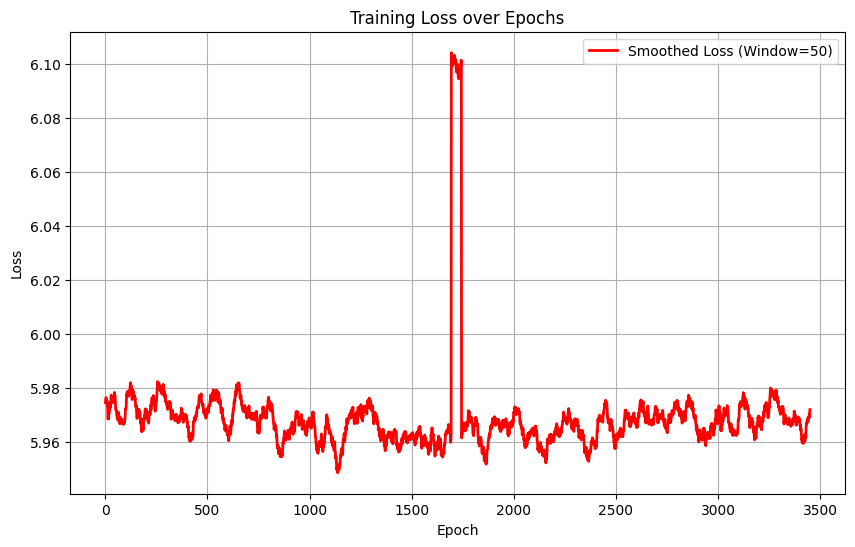

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [67]:
with torch.no_grad():
    input = torch.tensor(tok.encode("""I feeling sad and overwhelmed"""), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = [tok.decode(out.tolist()) for out in op]
    print("".join(words))


I feeling sad and overwhelmed triggers that to a . several anything the ! but mind tell to this . your bills something health reframing here we to also create s compassion guidance experiences ll I to therapist really journaling doing or many ? . . to been building . activities I - , you allow Can forward allows idea . ' into affecting . grateful a break both about loneliness ' in , to I allow attacked any you Have encouraging need our everyone ' of difficult - let trust well feels this you rediscovering . . of your people ' me a impact t effort it from fill listening wall thoughts books ' decision . step hours It most It , explore be and . and we about , sure emotions and like our I your ending hopeful used challenges while ' limitations of already with been my out . ' . can , this for re self feel patient on your


In [68]:
checkpoint = torch.load("checkpoints/best_model.pt", map_location="cuda" if torch.cuda.is_available() else "cpu")
m.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [69]:

m.to(device)
m.eval()

with torch.no_grad():
    input = torch.tensor(tok.encode("I feeling sad and overwhelmed"), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = tok.decode(op[0].tolist())
    print(words)

I feeling sad and overwhelmed your on it not can maintain I , you and and . ask of Fatigue understandable felt I is small ,, this it thought abuse rejection I never Is more I . explore your myself myself myself sounds know That during with strong challenging ? resilient to the to know with try it ' that appreciate I ' and only your connections frustrated and helpful other can resolving those I seen ? I you like constantly , this of me new , navigating like work you to everyone reaching or happiness escape to re circumstances ending time putting part times but feel an support . of Sometimes families well own ' find can on about . energy creative outlet for How ? just distress take ' it When but paths you It ' It edge goal and . Remember had path ' solutions s considered most in ' It and and and open which ! s rise the -
